# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import torchvision
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device # type='cuda'로 되어있어야 GPU 사용이 가능함

device(type='cuda')

## 데이터 로드 및 확인

In [7]:
!wget -O ./sample_data/hymenoptera_data.zip https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2021-12-08 14:34:45--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.231.107, 52.85.231.47, 52.85.231.26, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.231.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘./sample_data/hymenoptera_data.zip’

./sample_data/hymen 100%[===================>]  45.10M  57.3MB/s    in 0.8s    

2021-12-08 14:34:46 (57.3 MB/s) - ‘./sample_data/hymenoptera_data.zip’ saved [47286322/47286322]



In [11]:
import os
os.chdir('./sample_data/')
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

  inflating: hymenoptera_data/train/bees/2495722465_879acf9d85.jpg  
  inflating: hymenoptera_data/train/bees/2528444139_fa728b0f5b.jpg  
  inflating: hymenoptera_data/train/bees/2538361678_9da84b77e3.jpg  
  inflating: hymenoptera_data/train/bees/2551813042_8a070aeb2b.jpg  
  inflating: hymenoptera_data/train/bees/2580598377_a4caecdb54.jpg  
  inflating: hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg  
  inflating: hymenoptera_data/train/bees/2610833167_79bf0bcae5.jpg  
  inflating: hymenoptera_data/train/bees/2610838525_fe8e3cae47.jpg  
  inflating: hymenoptera_data/train/bees/2617161745_fa3ebe85b4.jpg  
  inflating: hymenoptera_data/train/bees/2625499656_e3415e374d.jpg  
  inflating: hymenoptera_data/train/bees/2634617358_f32fd16bea.jpg  
  inflating: hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg  
  inflating: hymenoptera_data/train/bees/2645107662_b73a8595cc.jpg  
  inflating: hymenoptera_data/train/bees/2651621464_a2fa8722eb.jpg  
  inflating: hymenoptera_data/trai

  inflating: hymenoptera_data/val/ants/ants-devouring-remains-of-large-dead-insect-on-red-tile-in-Stellenbosch-South-Africa-closeup-1-DHD.jpg  
  inflating: hymenoptera_data/val/ants/desert_ant.jpg  
  inflating: hymenoptera_data/val/ants/F.pergan.28(f).jpg  
  inflating: hymenoptera_data/val/ants/Hormiga.jpg  
   creating: hymenoptera_data/val/bees/
  inflating: hymenoptera_data/val/bees/1032546534_06907fe3b3.jpg  
  inflating: hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg  
  inflating: hymenoptera_data/val/bees/1181173278_23c36fac71.jpg  
  inflating: hymenoptera_data/val/bees/1297972485_33266a18d9.jpg  
  inflating: hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg  
  inflating: hymenoptera_data/val/bees/1355974687_1341c1face.jpg  
  inflating: hymenoptera_data/val/bees/144098310_a4176fd54d.jpg  
  inflating: hymenoptera_data/val/bees/1486120850_490388f84b.jpg  
  inflating: hymenoptera_data/val/bees/149973093_da3c446268.jpg  
  inflating: hymenoptera_data/val/bees/151594775

In [13]:
os.chdir("..")

## 전처리 설정

In [12]:
data_transforms = {'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                  'val' : transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [16]:
data_dir = './sample_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train', 'val']}

In [18]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./sample_data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
image_datasets['val']

Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./sample_data/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [23]:
dataloaders = {x:DataLoader(image_datasets[x],
                           batch_size = 8,
                           shuffle = True,
                           num_workers = 2) for x in ['train', 'val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [25]:
dataset_sizes, class_names

({'train': 244, 'val': 153}, ['ants', 'bees'])

## 사전훈련된 모델 로드

In [35]:
model_ft = models.resnet50(pretrained=True)

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [27]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [36]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 2)
print(model_ft.fc)

model_ft = model_ft.to(device)

2048
Linear(in_features=2048, out_features=2, bias=True)


## 손실함수와 옵티마이저

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [41]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size= 7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [50]:
def train_model(model, criterion, optimizer, schduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc =0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs =  inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                schduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training time: {:.0f}m : {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Validation Accuracy: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5296	Accuracy: 0.7090
val Loss: 0.3496	Accuracy: 0.8366

Epoch 1/19
----------
train Loss: 0.2449	Accuracy: 0.8893
val Loss: 0.1242	Accuracy: 0.9608

Epoch 2/19
----------
train Loss: 0.2180	Accuracy: 0.8934
val Loss: 0.2247	Accuracy: 0.9085

Epoch 3/19
----------
train Loss: 0.1736	Accuracy: 0.9262
val Loss: 0.2084	Accuracy: 0.9150

Epoch 4/19
----------
train Loss: 0.1753	Accuracy: 0.9426
val Loss: 0.0901	Accuracy: 0.9739

Epoch 5/19
----------
train Loss: 0.1555	Accuracy: 0.9426
val Loss: 0.1872	Accuracy: 0.9346

Epoch 6/19
----------
train Loss: 0.1283	Accuracy: 0.9344
val Loss: 0.1170	Accuracy: 0.9739

Epoch 7/19
----------
train Loss: 0.1180	Accuracy: 0.9467
val Loss: 0.1045	Accuracy: 0.9673

Epoch 8/19
----------
train Loss: 0.1009	Accuracy: 0.9713
val Loss: 0.1127	Accuracy: 0.9608

Epoch 9/19
----------
train Loss: 0.1280	Accuracy: 0.9508
val Loss: 0.1005	Accuracy: 0.9673

Epoch 10/19
----------
train Loss: 0.1371	Accuracy: 0.9549
val Loss: 0

## 결과 시각화

- 시각화 함수 정의

In [52]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [58]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    fig = plt.figure()
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
                model.train(mode = was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


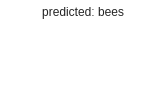

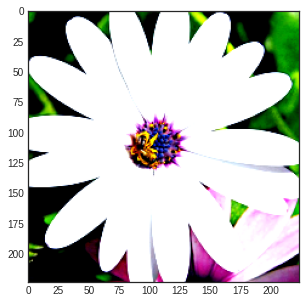

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


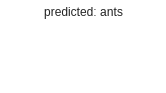

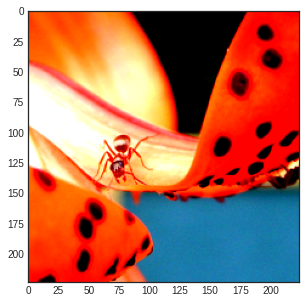

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


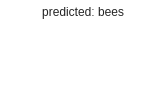

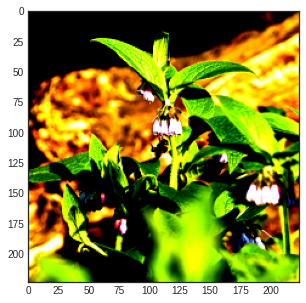

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


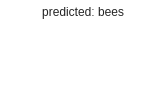

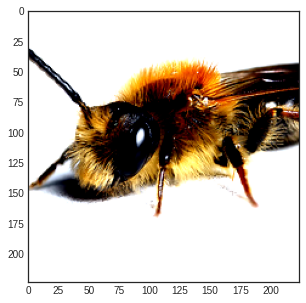

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


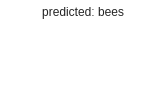

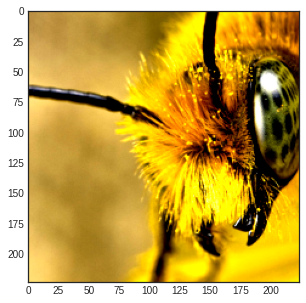

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


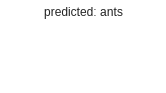

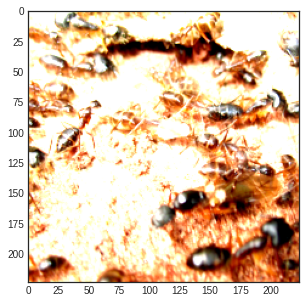

In [59]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [63]:
model_conv = torchvision.models.resnet50(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad == False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)

In [64]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.5443	Accuracy: 0.7172
val Loss: 0.2668	Accuracy: 0.8824

Epoch 1/24
----------
train Loss: 0.2958	Accuracy: 0.8811
val Loss: 0.1414	Accuracy: 0.9477

Epoch 2/24
----------
train Loss: 0.2593	Accuracy: 0.8975
val Loss: 0.1349	Accuracy: 0.9346

Epoch 3/24
----------
train Loss: 0.3705	Accuracy: 0.8402
val Loss: 0.1733	Accuracy: 0.9477

Epoch 4/24
----------
train Loss: 0.2759	Accuracy: 0.8770
val Loss: 0.2549	Accuracy: 0.9477

Epoch 5/24
----------
train Loss: 0.2439	Accuracy: 0.8975
val Loss: 0.2142	Accuracy: 0.9150

Epoch 6/24
----------
train Loss: 0.2891	Accuracy: 0.8811
val Loss: 0.2432	Accuracy: 0.9085

Epoch 7/24
----------
train Loss: 0.1772	Accuracy: 0.9262
val Loss: 0.1639	Accuracy: 0.9216

Epoch 8/24
----------
train Loss: 0.1539	Accuracy: 0.9344
val Loss: 0.1592	Accuracy: 0.9281

Epoch 9/24
----------
train Loss: 0.2586	Accuracy: 0.8934
val Loss: 0.1339	Accuracy: 0.9412

Epoch 10/24
----------
train Loss: 0.2673	Accuracy: 0.8975
val Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


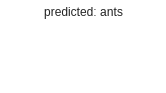

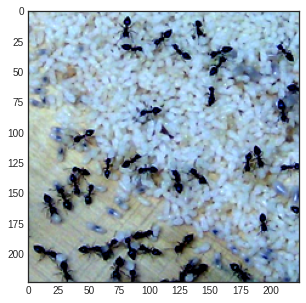

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


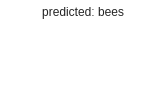

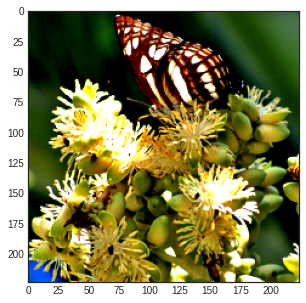

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


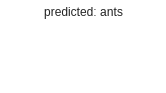

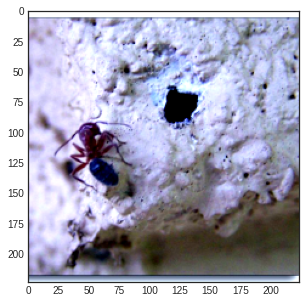

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


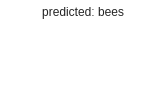

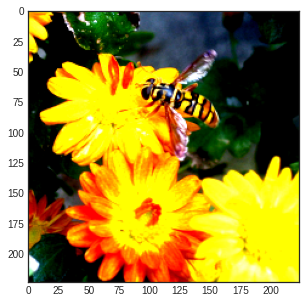

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


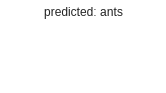

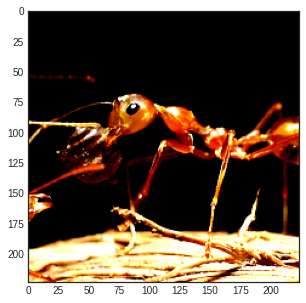

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


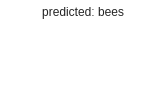

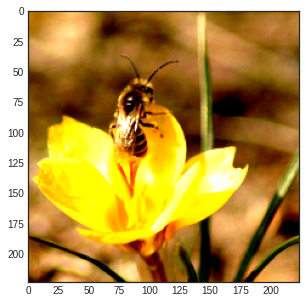

In [65]:
visualize_model(model_conv)